# <center> Challenge Large Scale Machine Learning <center>

## Introduction


### Fusion of algorithms for face recognition

The increasingly ubiquitous presence of biometric solutions and face recognition in particular in everyday life requires their adaptation for practical scenario. In the presence of several possible solutions, and if global decisions are to be made, each such single solution can be far less efficient than tailoring them to the complexity of an image.

In this challenge, the goal is to build a fusion of algorithms in order to construct the best suited solution for comparison of a pair of images. This fusion will be driven by qualities computed on each image.

Comparing of two images is done in two steps. 1st, a vector of features is computed for each image. 2nd, a simple function produces a vector of scores for a pair of images. The goal is to create a function that will compare a pair of images based on the information mentioned above, and decide whether two images belong to the same person.

You are provided a label set of training data and a test set without labels. You should submit a .csv file with labels for each entry of this test set.

# The properties of the dataset:


### Training data: 


The training set consist of two files, **xtrain_challenge.csv** and **xtest_challenge.csv**.

File **xtrain_challenge.csv** contains one observation per row which contains following entries based on a pair of images, A and B say:
 * columns 1-14 - 14 qualities on image A;
 * columns 15-28 - 14 qualities on image B;
 * columns 29-36 - 8 matching scores between A and B.

File **ytrain_challenge.csv** contains one line with each entry corresponding to one observation in **xtrain_challenge.csv**, maintaining the order, and has '1' if a pair of images belong to the same person and '0' otherwise.

There are in total 3.196.465 training observations.

### Test data:

File **xtest_challenge.csv** has the same structure as file **xtrain_challenge.csv**.

There are in total 1.598.219 test observations.

## The performance criterion

The performance criterion is the **prediction accuracy** on the test set, which is a value between 0 and 1, the higher the better.

# Training Data

Training data, input (file **xtrain_challenge.csv**): https://www.dropbox.com/s/myvvtmw61eg5gk7/xtrain_challenge.csv

Training data, output (file **ytrain_challenge.csv**): https://www.dropbox.com/s/cleumxob0dfzre4/ytrain_challenge.csv

# Test Data 

Test data, input (file **xtest_challenge.csv**): https://www.dropbox.com/s/bfrx8b4mqythm4q/xtest_challenge.csv

# Example submission

In [2]:
%matplotlib inline
import numpy as np
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
from sklearn import svm, datasets
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, roc_curve, auc, log_loss , roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier, GradientBoostingClassifier, RandomForestRegressor, VotingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression 
from scipy.sparse import csr_matrix, hstack
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
import lightgbm as lgb
import warnings 
warnings.filterwarnings("ignore")
sns.set()
from dask.diagnostics import ProgressBar

## Load and investigate the data

- First, we are going to work on a sample of the dataset in order to determine which preprocessing, feature engineering, models give the best accuracy and then train it on the whole dataset.

In [3]:
# Load training data
nrows_train = 5000
nrows_test = 5000
xtrain = pd.read_csv('xtrain_challenge.csv', nrows = nrows_train + nrows_test)
ytrain = pd.read_csv('ytrain_challenge.csv', nrows = nrows_train + nrows_test)
ytrain = np.array(ytrain).reshape(nrows_train + nrows_test)
# Check the number of observations and properties
print(xtrain.head(10))
print(ytrain[:10])
print(xtrain.shape)
print(ytrain.shape)

    fA1   fA2  fA3  fA4  fA5  fA6  fA7   fA8   fA9  fA10   ...    fB13  \
0  3.77  1.00  1.0   41  1.0  0.0  0.0 -0.17  0.03  0.00   ...    0.04   
1  1.47  0.01  0.0   62  1.0  0.0  0.0  0.30  0.02 -0.01   ...    0.01   
2  4.93  1.00  0.0   21  1.0  0.0  0.0  0.00  0.16  0.00   ...    0.07   
3  3.89  1.00  0.0   20  1.0  0.0  0.0 -0.35  0.09 -0.01   ...    0.10   
4  3.15  0.00  0.0   28  1.0  0.0  0.0  0.08 -0.08 -0.01   ...    0.01   
5  1.02  0.00  0.0   28  0.2  0.8  0.0 -0.73  0.00  0.03   ...    0.00   
6  1.28  1.00  0.0   21  1.0  0.0  0.0 -0.01 -0.01  0.00   ...   -0.06   
7  4.55  1.00  0.0   21  1.0  0.0  0.0  0.01 -0.13  0.00   ...   -0.02   
8  1.96  0.98  0.0   20  1.0  0.0  0.0  0.00  0.02  0.00   ...    0.01   
9  3.50  0.01  0.0   25  1.0  0.0  0.0  0.00  0.03  0.00   ...    0.00   

     fB14      s1      s2      s3      s4      s5      s6      s7      s8  
0  271.80  2464.1  2117.2  1760.6  2241.3  1900.3  1462.8  2344.9  1949.8  
1  157.15  3975.9  2640.9  2672.6

### Data Analysis

In [35]:
xtrain.head()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,3.77,1.00,1.0,41,1.0,0.0,0.0,-0.17,0.03,0.00,...,0.04,271.80,2464.1,2117.2,1760.6,2241.3,1900.3,1462.8,2344.9,1949.8
1,1.47,0.01,0.0,62,1.0,0.0,0.0,0.30,0.02,-0.01,...,0.01,157.15,3975.9,2640.9,2672.6,4233.8,3357.9,2224.0,3341.1,3611.5
2,4.93,1.00,0.0,21,1.0,0.0,0.0,0.00,0.16,0.00,...,0.07,283.33,3401.1,2644.3,2514.2,3551.3,3019.7,3414.7,2763.6,3252.2
3,3.89,1.00,0.0,20,1.0,0.0,0.0,-0.35,0.09,-0.01,...,0.10,298.40,2418.6,2659.6,2742.1,3422.4,2602.6,2784.0,2697.4,2505.1
4,3.15,0.00,0.0,28,1.0,0.0,0.0,0.08,-0.08,-0.01,...,0.01,248.69,2309.1,2164.0,1755.6,2377.4,1994.6,2147.6,1902.9,2599.5


In [5]:
xtrain.describe()

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,3.113479,0.723046,0.091600,29.330500,0.904998,0.004042,0.090916,0.141980,0.030962,-0.000322,...,-0.004556,246.479599,3857.747560,2433.23160,4184.918530,4223.548420,3492.164450,3401.894820,3499.561760,3736.797930
std,1.620015,0.420065,0.286403,9.723236,0.284652,0.043863,0.282136,0.427612,0.130202,0.020441,...,0.058879,124.951683,2057.706359,228.65682,2937.032332,2124.621634,1362.062239,1357.687012,1062.972169,1550.734162
min,-0.340000,0.000000,0.000000,18.000000,0.000000,0.000000,0.000000,-2.210000,-2.780000,-0.230000,...,-0.420000,-258.680000,1338.500000,1660.70000,835.000000,1358.600000,826.400000,1002.600000,1782.100000,1038.700000
25%,1.910000,0.260000,0.000000,22.000000,1.000000,0.000000,0.000000,-0.020000,-0.020000,0.000000,...,-0.040000,222.495000,2408.675000,2296.17500,2083.075000,2715.175000,2454.500000,2330.175000,2737.275000,2613.225000
50%,3.410000,1.000000,0.000000,26.000000,1.000000,0.000000,0.000000,0.010000,0.020000,0.000000,...,-0.010000,277.400000,3055.500000,2439.00000,3072.050000,3387.900000,3075.750000,3011.500000,3147.450000,3216.750000
75%,4.370000,1.000000,0.000000,34.000000,1.000000,0.000000,0.000000,0.110000,0.080000,0.010000,...,0.020000,322.320000,4421.625000,2586.10000,5120.825000,4900.550000,4408.800000,4372.725000,3895.800000,4405.075000
max,7.330000,1.000000,1.000000,73.000000,1.000000,0.990000,1.000000,2.260000,0.580000,0.200000,...,0.340000,444.640000,11095.200000,3021.70000,15726.000000,10750.300000,7164.300000,7302.200000,6616.300000,8088.700000


- There is no empty values in the dataset. 

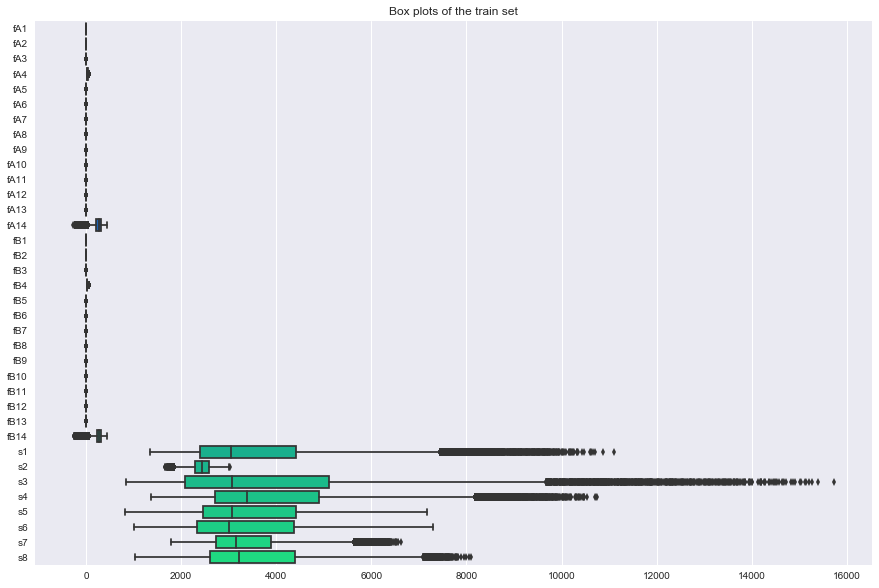

In [32]:
plt.figure(figsize= (15,10))
sns.boxplot(data= xtrain, orient="h", palette="winter")
plt.title('Box plots of the train set')
plt.show()

- Most of the features fA and fB don't have big variance and don't takes big values compared to the s[1:8] features.

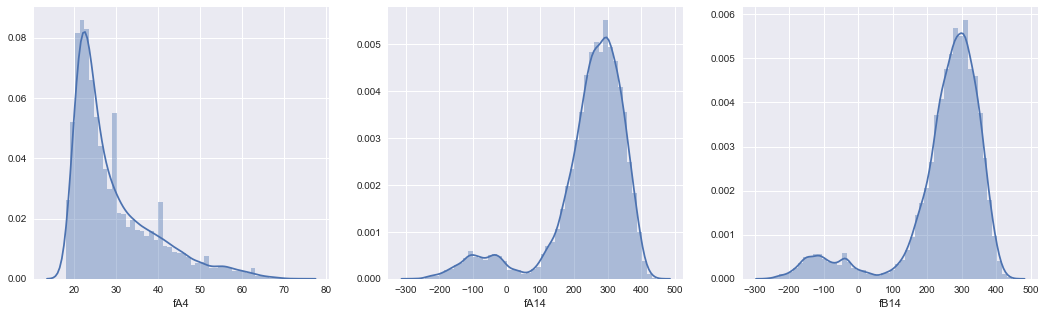

In [29]:
plt.figure(1, figsize=(18, 5))
plt.subplot(131)
sns.distplot(xtrain['fA4']);
plt.subplot(132)
sns.distplot(xtrain['fA14']);
plt.subplot(133)
sns.distplot(xtrain['fB14']);
plt.show()

- fA4, fA14 and fB14 have skewed distribution.
- fA14 and fB14 have bimodals distributions.

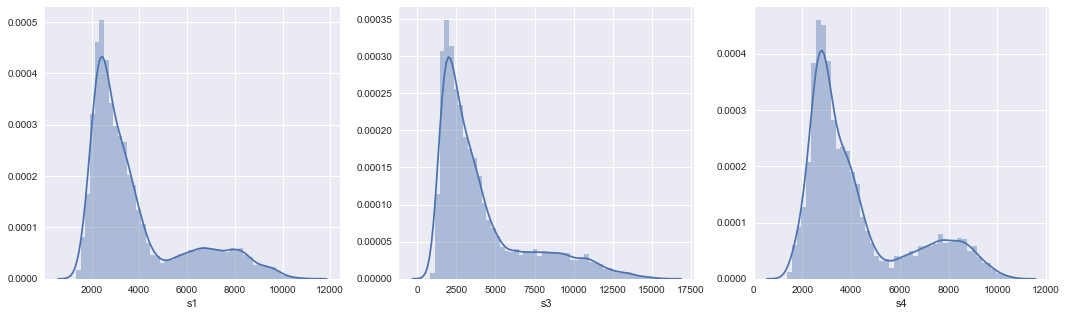

In [36]:
plt.figure(1, figsize=(18, 5))
plt.subplot(131)
sns.distplot(xtrain['s1']);
plt.subplot(132)
sns.distplot(xtrain['s3']);
plt.subplot(133)
sns.distplot(xtrain['s4']);
plt.show()

- s1, s3 and s4 have skewed distributions.
- The data are better distributed than before, they have bimodal distribution  but the second mode is platykurtic.

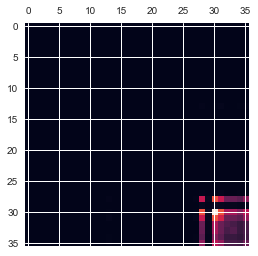

In [8]:
plt.matshow(xtrain.cov())
plt.show()

- Most of the features are uncorrelated except for some of the s[1:8] features.

### Analysis of the ytrain

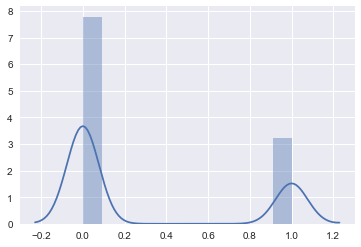

In [37]:
sns.distplot(ytrain);

We work on an inbalance dataset.

### Split of the data in train set and test set

In [38]:
# Split of training set in order to measure the accuracy in local.
Xtrain, Xtest, Ytrain, Ytest = train_test_split(xtrain, ytrain, test_size=0.3, random_state=100)

In [39]:
Xtrain.reset_index(inplace=True, drop =True)
Xtest.reset_index(inplace=True, drop =True)
print(Xtrain.shape)
print(Xtest.shape)
display("Xtrain", Xtrain.head())
display("Xtest", Xtest.head())

(7000, 36)
(3000, 36)


'Xtrain'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,1.00,1.00,0.0,25,1.00,0.0,0.00,-0.10,-0.01,0.00,...,-0.08,240.59,4133.7,2292.6,3573.9,3753.1,3343.4,3246.9,3372.0,3704.3
1,2.31,0.99,0.0,27,1.00,0.0,0.00,0.01,0.02,0.00,...,0.04,122.18,3765.9,2413.7,3636.1,3526.2,4349.2,2615.4,3394.9,3804.8
2,4.05,1.00,0.0,30,0.86,0.0,0.14,0.18,0.11,-0.01,...,0.04,190.39,2083.3,2065.9,2421.9,2655.8,2865.0,1871.0,2381.8,2261.9
3,3.91,0.00,0.0,25,1.00,0.0,0.00,0.01,0.14,-0.01,...,0.01,330.69,3273.7,2521.5,3905.2,3770.9,3480.9,2731.3,3596.0,3673.6
4,2.94,1.00,0.0,19,1.00,0.0,0.00,0.04,0.04,0.01,...,0.05,343.02,4147.5,2395.5,4299.7,4321.2,3678.5,3390.6,3132.7,3926.0


'Xtest'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,1.30,0.27,1.0,34,0.0,0.0,1.0,1.55,0.01,0.00,...,0.02,-66.22,2132.3,2297.7,3219.0,1956.1,4278.7,2826.5,2769.5,1666.1
1,4.69,1.00,0.0,21,1.0,0.0,0.0,0.47,0.08,-0.02,...,0.06,363.31,7498.9,2417.8,8174.0,7333.3,5552.5,5545.0,5458.5,6170.9
2,2.69,1.00,0.0,31,1.0,0.0,0.0,0.10,-0.10,0.00,...,-0.05,373.07,2210.6,2015.2,1458.2,2685.7,2331.6,1243.9,2374.0,2263.3
3,4.19,1.00,0.0,24,1.0,0.0,0.0,0.01,-0.06,0.00,...,0.02,289.23,8943.7,2925.8,12522.9,8904.6,6307.4,6528.7,5863.9,6978.4
4,5.34,1.00,0.0,26,1.0,0.0,0.0,0.00,-0.05,-0.01,...,-0.02,309.20,2281.4,2391.2,2743.5,2815.9,2627.5,1996.2,2806.7,2879.7


### PCA :

In [47]:
pca = PCA(n_components= 0.99, svd_solver= 'full') 
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

Choosing features that explains 0.99 of the variance.

### Feature scaling and normalization

In [44]:
# Feature scaling and normalization of the dataset => X_FS.
Xtrain_fs=(Xtrain-Xtrain.mean())/Xtrain.std()
Xtest_fs=(Xtest-Xtest.mean())/Xtest.std()

In [45]:
display("Xtrain_fs", Xtrain_fs.head())
display("Xtest_fs", Xtest_fs.head())

'Xtrain_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,-1.302889,0.656587,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.563287,-0.305024,0.020740,...,-1.263984,-0.050108,0.132980,-0.617577,-0.212722,-0.224282,-0.114711,-0.117903,-0.125911,-0.026169
1,-0.495633,0.632706,-0.323057,-0.242357,0.335371,-0.093948,-0.323334,-0.308461,-0.079653,0.020740,...,0.747319,-0.994964,-0.045452,-0.087913,-0.191640,-0.330627,0.621385,-0.583036,-0.104433,0.038389
2,0.576600,0.656587,-0.323057,0.064794,-0.154996,-0.093948,0.171284,0.085360,0.596461,-0.463183,...,0.747319,-0.450680,-0.861741,-1.609113,-0.603181,-0.738573,-0.464829,-1.131325,-1.054614,-0.952721
3,0.490328,-1.731524,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.308461,0.821832,-0.463183,...,0.244493,0.668848,-0.284236,0.383581,-0.100432,-0.215939,-0.014082,-0.497669,0.084177,-0.045890
4,-0.107411,0.656587,-0.323057,-1.061427,0.335371,-0.093948,-0.323334,-0.238963,0.070595,0.504662,...,0.914927,0.767236,0.139675,-0.167515,0.033280,0.041980,0.130532,-0.012060,-0.350349,0.116244


'Xtest_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,-1.122534,-1.059495,3.255958,0.494231,-3.207421,-0.087812,3.251265,3.374581,-0.177011,0.003683,...,0.429395,-2.512358,-0.839717,-0.586717,-0.319089,-1.068863,0.595551,-0.415022,-0.676973,-1.334969
1,0.978089,0.665579,-0.312163,-0.856979,0.329890,-0.087812,-0.319631,0.791182,0.391372,-1.000856,...,1.130924,0.948734,1.778550,-0.061666,1.386139,1.487180,1.537754,1.587021,1.870941,1.596475
2,-0.261217,0.665579,-0.312163,0.182413,0.329890,-0.087812,-0.319631,-0.093871,-1.070185,0.003683,...,-0.798282,1.027379,-0.801516,-1.821745,-0.925056,-0.722049,-0.844678,-1.580530,-1.051722,-0.946348
3,0.668262,0.665579,-0.312163,-0.545161,0.329890,-0.087812,-0.319631,-0.309155,-0.745394,0.003683,...,0.429395,0.351808,2.483441,2.159198,2.882782,2.234094,2.096138,2.311469,2.255071,2.121945
4,1.380863,0.665579,-0.312163,-0.337283,0.329890,-0.087812,-0.319631,-0.333075,-0.664196,-0.498586,...,-0.272135,0.512723,-0.766974,-0.177956,-0.482729,-0.660158,-0.625807,-1.026498,-0.641725,-0.545234


## Feature engineering

### Linear Combinations

- We can see that the data in the columns 's1, 's3', 's4', 's5', 's6', 's7', 's8' are quite and looks like to have correlation when we do sns.pairplot() those are positively correlated.

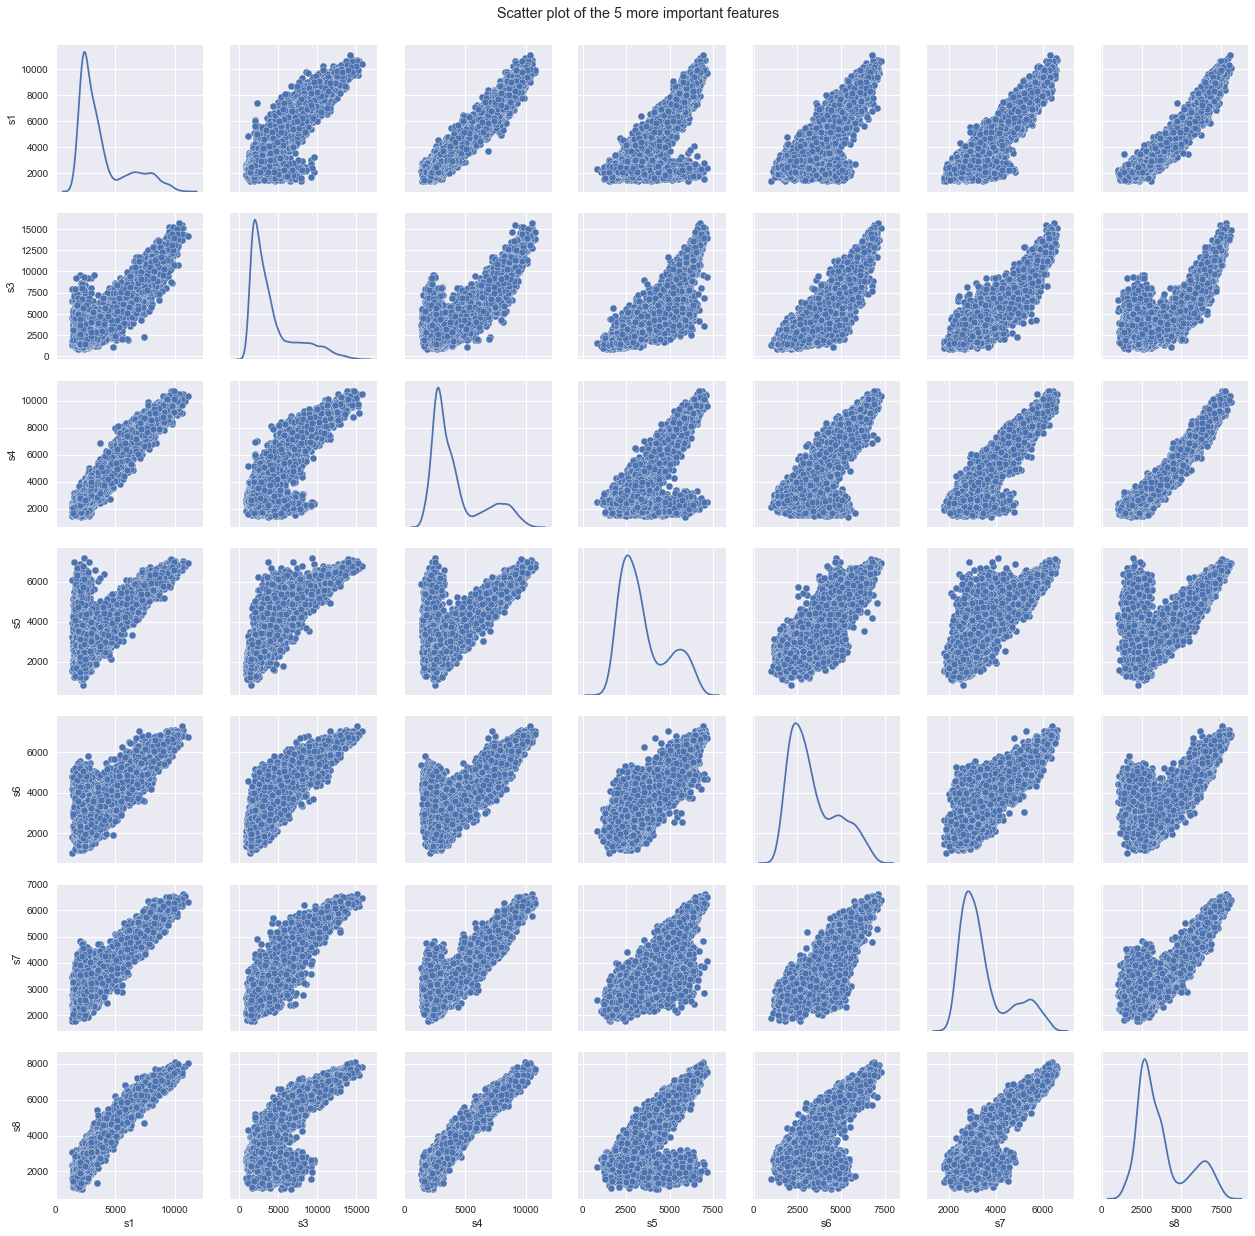

In [48]:
S = ['s1', 's3', 's4', 's5', 's6', 's7', 's8']
sns.pairplot(xtrain, x_vars= S, y_vars= S, diag_kind="kde")
plt.subplots_adjust(top=0.95)
g = plt.gcf()
g.suptitle("Scatter plot of the 5 more important features")
plt.show()

- The idea is to create a new feature which is the mean of the correlated features.

In [49]:
# Mean of sX columns:
new1 = Xtrain['s1'].copy(deep=True)
s = ['s3', 's4', 's5', 's6', 's7', 's8']

for i in s:
    new1 += Xtrain[i].copy(deep=True)
new1/len(s)
Xtrain_lc = Xtrain.copy(deep=True)
Xtrain_lc['smean'] = new1 

In [50]:
# Mean of sX columns:
new2 = Xtest['s1'].copy(deep=True)
s = ['s3', 's4', 's5', 's6', 's7', 's8']

for i in s:
    new2 += Xtest[i].copy(deep=True)
new2/len(s)
Xtest_lc = Xtest.copy(deep=True)
Xtest_lc['smean'] = new2 

In [51]:
print(Xtrain_lc.shape)
print(Xtest_lc.shape)
display("Xtrain_lc", Xtrain_lc.head())
display("Xtest_lc", Xtest_lc.head())

(7000, 37)
(3000, 37)


'Xtrain_lc'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB14,s1,s2,s3,s4,s5,s6,s7,s8,smean
0,1.00,1.00,0.0,25,1.00,0.0,0.00,-0.10,-0.01,0.00,...,240.59,4133.7,2292.6,3573.9,3753.1,3343.4,3246.9,3372.0,3704.3,25127.3
1,2.31,0.99,0.0,27,1.00,0.0,0.00,0.01,0.02,0.00,...,122.18,3765.9,2413.7,3636.1,3526.2,4349.2,2615.4,3394.9,3804.8,25092.5
2,4.05,1.00,0.0,30,0.86,0.0,0.14,0.18,0.11,-0.01,...,190.39,2083.3,2065.9,2421.9,2655.8,2865.0,1871.0,2381.8,2261.9,16540.7
3,3.91,0.00,0.0,25,1.00,0.0,0.00,0.01,0.14,-0.01,...,330.69,3273.7,2521.5,3905.2,3770.9,3480.9,2731.3,3596.0,3673.6,24431.6
4,2.94,1.00,0.0,19,1.00,0.0,0.00,0.04,0.04,0.01,...,343.02,4147.5,2395.5,4299.7,4321.2,3678.5,3390.6,3132.7,3926.0,26896.2


'Xtest_lc'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB14,s1,s2,s3,s4,s5,s6,s7,s8,smean
0,1.30,0.27,1.0,34,0.0,0.0,1.0,1.55,0.01,0.00,...,-66.22,2132.3,2297.7,3219.0,1956.1,4278.7,2826.5,2769.5,1666.1,18848.2
1,4.69,1.00,0.0,21,1.0,0.0,0.0,0.47,0.08,-0.02,...,363.31,7498.9,2417.8,8174.0,7333.3,5552.5,5545.0,5458.5,6170.9,45733.1
2,2.69,1.00,0.0,31,1.0,0.0,0.0,0.10,-0.10,0.00,...,373.07,2210.6,2015.2,1458.2,2685.7,2331.6,1243.9,2374.0,2263.3,14567.3
3,4.19,1.00,0.0,24,1.0,0.0,0.0,0.01,-0.06,0.00,...,289.23,8943.7,2925.8,12522.9,8904.6,6307.4,6528.7,5863.9,6978.4,56049.6
4,5.34,1.00,0.0,26,1.0,0.0,0.0,0.00,-0.05,-0.01,...,309.20,2281.4,2391.2,2743.5,2815.9,2627.5,1996.2,2806.7,2879.7,18150.9


### Gradient Boosting Classifiers

Here I create a dataset with the leafs of a tree made with GradientBoosting model as new features.

In [60]:
gb = GradientBoostingClassifier(n_estimators= 50, learning_rate= 0.8, verbose= True)
gb.fit(Xtrain, Ytrain)

      Iter       Train Loss   Remaining Time 
         1           0.4284            0.59s
         2           0.2990            0.67s
         3           0.2423            0.77s
         4           0.2090            0.76s
         5           0.1921            0.71s
         6           0.1743            0.66s
         7           0.1691            0.61s
         8           0.1594            0.58s
         9           0.1548            0.54s
        10           0.1441            0.52s
        20           0.0974            0.33s
        30           0.0656            0.21s
        40           0.0478            0.10s
        50           0.0284            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.8, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=1.0,
              verbose=True, warm_start=False)

In [61]:
gb.estimators_

array([[DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x1052d2750>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x1052d2750>,
           splitter='best')],
       [DecisionTreeRegressor(criterion='friedman_mse', max_depth=3,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_sa

In [62]:
leafs_train = gb.apply(Xtrain)
leafs_test = gb.apply(Xtest)
print(leafs_train.shape)

(7000, 50, 1)


In [63]:
leafs_train = pd.DataFrame(np.reshape(leafs_train, (leafs_train.shape[0], leafs_train.shape[1]))) 
leafs_test = pd.DataFrame(np.reshape(leafs_test, (leafs_test.shape[0], leafs_test.shape[1])))
print(leafs_train.shape, leafs_test.shape)

(7000, 50) (3000, 50)


In [64]:
print(type(leafs_train))
print(leafs_train.shape)
leafs_train.head()

<class 'pandas.core.frame.DataFrame'>
(7000, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,6.0,3.0,7.0,7.0,10.0,4.0,5.0,6.0,6.0,10.0,...,3.0,3.0,13.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0
1,3.0,3.0,13.0,3.0,10.0,4.0,5.0,6.0,6.0,11.0,...,3.0,3.0,13.0,6.0,14.0,4.0,3.0,10.0,13.0,4.0
2,6.0,3.0,7.0,6.0,3.0,11.0,7.0,6.0,9.0,4.0,...,6.0,3.0,4.0,11.0,4.0,4.0,4.0,10.0,14.0,4.0
3,6.0,3.0,7.0,7.0,10.0,4.0,7.0,6.0,6.0,11.0,...,6.0,3.0,4.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0
4,6.0,3.0,14.0,7.0,10.0,4.0,5.0,13.0,6.0,10.0,...,6.0,3.0,13.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0


In [65]:
print(type(leafs_test))
print(leafs_test.shape)
leafs_test.head()

<class 'pandas.core.frame.DataFrame'>
(3000, 50)


,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,3.0,3.0,10.0,3.0,3.0,12.0,5.0,6.0,9.0,3.0,...,3.0,4.0,4.0,11.0,4.0,4.0,3.0,10.0,6.0,3.0
1,14.0,14.0,14.0,14.0,10.0,12.0,7.0,14.0,6.0,10.0,...,6.0,3.0,13.0,11.0,14.0,4.0,3.0,14.0,14.0,14.0
2,6.0,3.0,7.0,6.0,3.0,11.0,5.0,6.0,9.0,4.0,...,3.0,3.0,4.0,10.0,4.0,4.0,4.0,10.0,3.0,4.0
3,14.0,14.0,14.0,14.0,10.0,7.0,5.0,13.0,6.0,10.0,...,6.0,3.0,13.0,6.0,14.0,4.0,3.0,14.0,14.0,14.0
4,6.0,3.0,7.0,7.0,3.0,4.0,5.0,6.0,6.0,4.0,...,6.0,3.0,4.0,6.0,4.0,4.0,3.0,10.0,14.0,4.0


In [66]:
Xtrain_concat = pd.concat([Xtrain.copy(deep=True), leafs_train], axis=1)
Xtest_concat = pd.concat([Xtest.copy(), leafs_test], axis=1)

In [67]:
print(Xtrain_concat.shape)
print(Xtest_concat.shape)
display("Xtrain_concat", Xtrain_concat.head())
display("Xtest_concat", Xtest_concat.head())

(7000, 86)
(3000, 86)


'Xtrain_concat'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,40,41,42,43,44,45,46,47,48,49
0,1.00,1.00,0.0,25,1.00,0.0,0.00,-0.10,-0.01,0.00,...,3.0,3.0,13.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0
1,2.31,0.99,0.0,27,1.00,0.0,0.00,0.01,0.02,0.00,...,3.0,3.0,13.0,6.0,14.0,4.0,3.0,10.0,13.0,4.0
2,4.05,1.00,0.0,30,0.86,0.0,0.14,0.18,0.11,-0.01,...,6.0,3.0,4.0,11.0,4.0,4.0,4.0,10.0,14.0,4.0
3,3.91,0.00,0.0,25,1.00,0.0,0.00,0.01,0.14,-0.01,...,6.0,3.0,4.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0
4,2.94,1.00,0.0,19,1.00,0.0,0.00,0.04,0.04,0.01,...,6.0,3.0,13.0,6.0,14.0,4.0,4.0,10.0,14.0,4.0


'Xtest_concat'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,40,41,42,43,44,45,46,47,48,49
0,1.30,0.27,1.0,34,0.0,0.0,1.0,1.55,0.01,0.00,...,3.0,4.0,4.0,11.0,4.0,4.0,3.0,10.0,6.0,3.0
1,4.69,1.00,0.0,21,1.0,0.0,0.0,0.47,0.08,-0.02,...,6.0,3.0,13.0,11.0,14.0,4.0,3.0,14.0,14.0,14.0
2,2.69,1.00,0.0,31,1.0,0.0,0.0,0.10,-0.10,0.00,...,3.0,3.0,4.0,10.0,4.0,4.0,4.0,10.0,3.0,4.0
3,4.19,1.00,0.0,24,1.0,0.0,0.0,0.01,-0.06,0.00,...,6.0,3.0,13.0,6.0,14.0,4.0,3.0,14.0,14.0,14.0
4,5.34,1.00,0.0,26,1.0,0.0,0.0,0.00,-0.05,-0.01,...,6.0,3.0,4.0,6.0,4.0,4.0,3.0,10.0,14.0,4.0


- Problem of consistence in the number of sample...

### Feature scaling and normalization

In [68]:
# Feature scaling and normalization of the dataset => X_FS.
Xtrain_fs=(Xtrain-Xtrain.mean())/Xtrain.std()
Xtest_fs=(Xtest-Xtest.mean())/Xtest.std()

In [69]:
display("Xtrain_fs", Xtrain_fs.head())
display("Xtest_fs", Xtest_fs.head())

'Xtrain_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,-1.302889,0.656587,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.563287,-0.305024,0.020740,...,-1.263984,-0.050108,0.132980,-0.617577,-0.212722,-0.224282,-0.114711,-0.117903,-0.125911,-0.026169
1,-0.495633,0.632706,-0.323057,-0.242357,0.335371,-0.093948,-0.323334,-0.308461,-0.079653,0.020740,...,0.747319,-0.994964,-0.045452,-0.087913,-0.191640,-0.330627,0.621385,-0.583036,-0.104433,0.038389
2,0.576600,0.656587,-0.323057,0.064794,-0.154996,-0.093948,0.171284,0.085360,0.596461,-0.463183,...,0.747319,-0.450680,-0.861741,-1.609113,-0.603181,-0.738573,-0.464829,-1.131325,-1.054614,-0.952721
3,0.490328,-1.731524,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.308461,0.821832,-0.463183,...,0.244493,0.668848,-0.284236,0.383581,-0.100432,-0.215939,-0.014082,-0.497669,0.084177,-0.045890
4,-0.107411,0.656587,-0.323057,-1.061427,0.335371,-0.093948,-0.323334,-0.238963,0.070595,0.504662,...,0.914927,0.767236,0.139675,-0.167515,0.033280,0.041980,0.130532,-0.012060,-0.350349,0.116244


'Xtest_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB13,fB14,s1,s2,s3,s4,s5,s6,s7,s8
0,-1.122534,-1.059495,3.255958,0.494231,-3.207421,-0.087812,3.251265,3.374581,-0.177011,0.003683,...,0.429395,-2.512358,-0.839717,-0.586717,-0.319089,-1.068863,0.595551,-0.415022,-0.676973,-1.334969
1,0.978089,0.665579,-0.312163,-0.856979,0.329890,-0.087812,-0.319631,0.791182,0.391372,-1.000856,...,1.130924,0.948734,1.778550,-0.061666,1.386139,1.487180,1.537754,1.587021,1.870941,1.596475
2,-0.261217,0.665579,-0.312163,0.182413,0.329890,-0.087812,-0.319631,-0.093871,-1.070185,0.003683,...,-0.798282,1.027379,-0.801516,-1.821745,-0.925056,-0.722049,-0.844678,-1.580530,-1.051722,-0.946348
3,0.668262,0.665579,-0.312163,-0.545161,0.329890,-0.087812,-0.319631,-0.309155,-0.745394,0.003683,...,0.429395,0.351808,2.483441,2.159198,2.882782,2.234094,2.096138,2.311469,2.255071,2.121945
4,1.380863,0.665579,-0.312163,-0.337283,0.329890,-0.087812,-0.319631,-0.333075,-0.664196,-0.498586,...,-0.272135,0.512723,-0.766974,-0.177956,-0.482729,-0.660158,-0.625807,-1.026498,-0.641725,-0.545234


In [70]:
# Feature scaling and normalization of the dataset => Xtrain_lc_fs.
Xtrain_lc_fs=(Xtrain_lc-Xtrain_lc.mean())/Xtrain_lc.std()
Xtest_lc_fs=(Xtest_lc-Xtest_lc.mean())/Xtest_lc.std()
display("Xtrain_lc_fs", Xtrain_lc_fs.head())
display("Xtest_lc_fs", Xtest_lc_fs.head())

'Xtrain_lc_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB14,s1,s2,s3,s4,s5,s6,s7,s8,smean
0,-1.302889,0.656587,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.563287,-0.305024,0.020740,...,-0.050108,0.132980,-0.617577,-0.212722,-0.224282,-0.114711,-0.117903,-0.125911,-0.026169,-0.111273
1,-0.495633,0.632706,-0.323057,-0.242357,0.335371,-0.093948,-0.323334,-0.308461,-0.079653,0.020740,...,-0.994964,-0.045452,-0.087913,-0.191640,-0.330627,0.621385,-0.583036,-0.104433,0.038389,-0.114198
2,0.576600,0.656587,-0.323057,0.064794,-0.154996,-0.093948,0.171284,0.085360,0.596461,-0.463183,...,-0.450680,-0.861741,-1.609113,-0.603181,-0.738573,-0.464829,-1.131325,-1.054614,-0.952721,-0.833004
3,0.490328,-1.731524,-0.323057,-0.447124,0.335371,-0.093948,-0.323334,-0.308461,0.821832,-0.463183,...,0.668848,-0.284236,0.383581,-0.100432,-0.215939,-0.014082,-0.497669,0.084177,-0.045890,-0.169748
4,-0.107411,0.656587,-0.323057,-1.061427,0.335371,-0.093948,-0.323334,-0.238963,0.070595,0.504662,...,0.767236,0.139675,-0.167515,0.033280,0.041980,0.130532,-0.012060,-0.350349,0.116244,0.037409


'Xtest_lc_fs'

,fA1,fA2,fA3,fA4,fA5,fA6,fA7,fA8,fA9,fA10,...,fB14,s1,s2,s3,s4,s5,s6,s7,s8,smean
0,-1.122534,-1.059495,3.255958,0.494231,-3.207421,-0.087812,3.251265,3.374581,-0.177011,0.003683,...,-2.512358,-0.839717,-0.586717,-0.319089,-1.068863,0.595551,-0.415022,-0.676973,-1.334969,-0.630519
1,0.978089,0.665579,-0.312163,-0.856979,0.329890,-0.087812,-0.319631,0.791182,0.391372,-1.000856,...,0.948734,1.778550,-0.061666,1.386139,1.487180,1.537754,1.587021,1.870941,1.596475,1.653655
2,-0.261217,0.665579,-0.312163,0.182413,0.329890,-0.087812,-0.319631,-0.093871,-1.070185,0.003683,...,1.027379,-0.801516,-1.821745,-0.925056,-0.722049,-0.844678,-1.580530,-1.051722,-0.946348,-0.994230
3,0.668262,0.665579,-0.312163,-0.545161,0.329890,-0.087812,-0.319631,-0.309155,-0.745394,0.003683,...,0.351808,2.483441,2.159198,2.882782,2.234094,2.096138,2.311469,2.255071,2.121945,2.530157
4,1.380863,0.665579,-0.312163,-0.337283,0.329890,-0.087812,-0.319631,-0.333075,-0.664196,-0.498586,...,0.512723,-0.766974,-0.177956,-0.482729,-0.660158,-0.625807,-1.026498,-0.641725,-0.545234,-0.689763


### Random Forest Classifier

In [72]:
rdf = RandomForestClassifier(n_jobs=-1)
rdf.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [73]:
features = xtrain.columns
print(features)

Index(['fA1', 'fA2', 'fA3', 'fA4', 'fA5', 'fA6', 'fA7', 'fA8', 'fA9', 'fA10',
       'fA11', 'fA12', 'fA13', 'fA14', 'fB1', 'fB2', 'fB3', 'fB4', 'fB5',
       'fB6', 'fB7', 'fB8', 'fB9', 'fB10', 'fB11', 'fB12', 'fB13', 'fB14',
       's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8'],
      dtype='object')


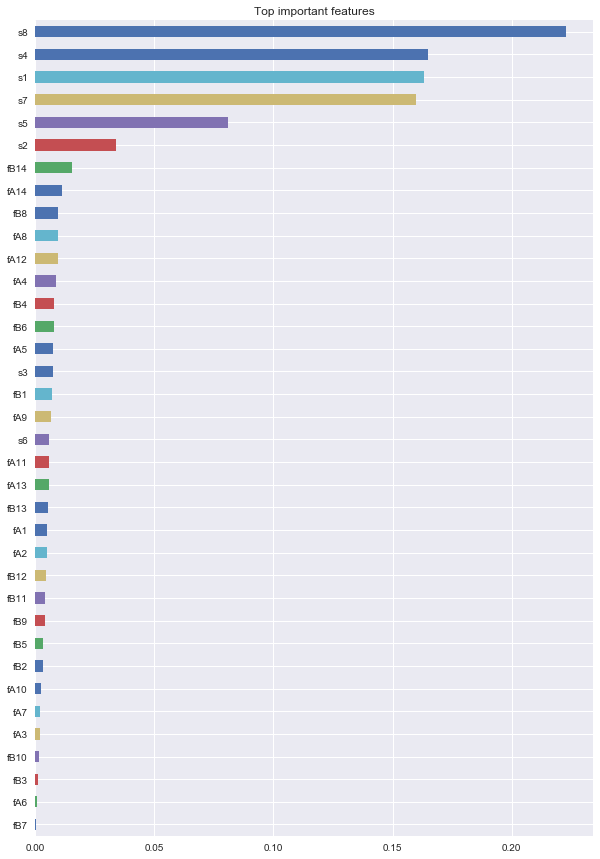

In [74]:
# Computing the feautre importance with the random forest classifier. 
feat_importances = pd.Series(rdf.feature_importances_, index=features)
feat_importances.nlargest(len(features)).iloc[::-1].plot(kind='barh', figsize=[10, 15], title="Top important features")
plt.show()

- We can observe there is some features which have much more importance than the others, and features which have no importance.

In [76]:
features_selected = feat_importances.nlargest(len(features))[:5]

In [77]:
# Exclude features without importances.
imp = feat_importances.nlargest(len(features))[:22]

In [78]:
cols_to_keep = imp.index.tolist()
print(cols_to_keep)

['s8', 's4', 's1', 's7', 's5', 's2', 'fB14', 'fA14', 'fB8', 'fA8', 'fA12', 'fA4', 'fB4', 'fB6', 'fA5', 's3', 'fB1', 'fA9', 's6', 'fA11', 'fA13', 'fB13']


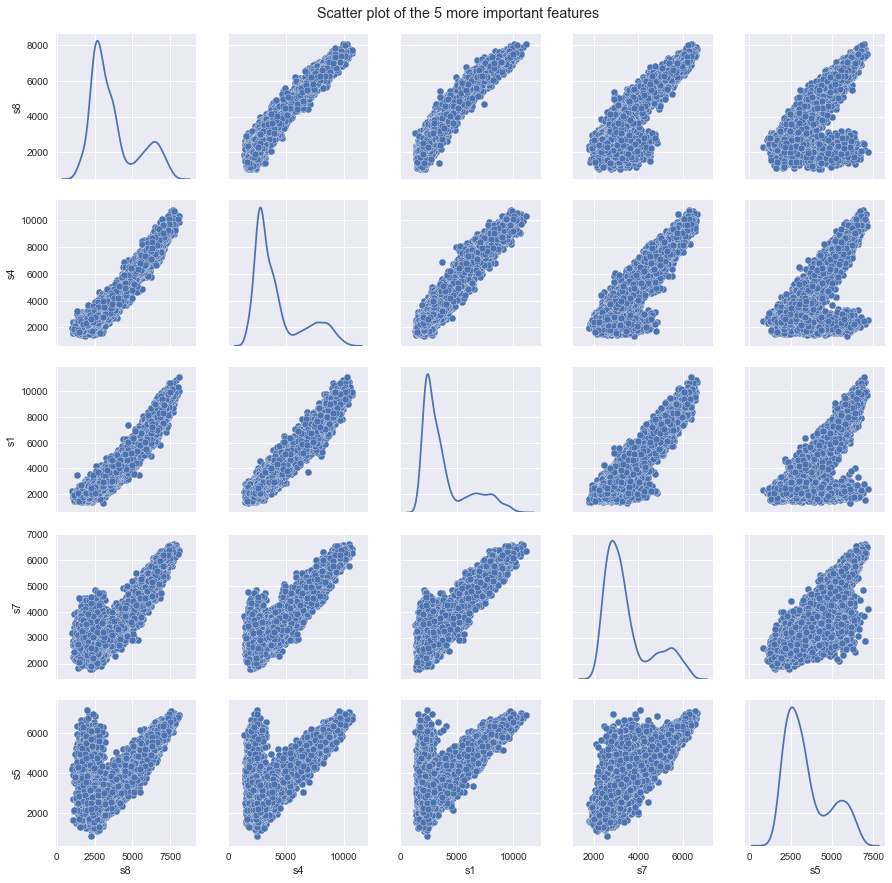

In [79]:
# Sélection de 4 variables explicatives au hasard. Détermination des 
sns.pairplot(xtrain, x_vars= features_selected.index, y_vars= features_selected.index, diag_kind="kde")
plt.subplots_adjust(top=0.95)
g = plt.gcf()
g.suptitle("Scatter plot of the 5 more important features")
plt.show()

- We can see that some features are positively correlated: S5, S8, S1 and S4

In [80]:
Xtrain[cols_to_keep].head()

,s8,s4,s1,s7,s5,s2,fB14,fA14,fB8,fA8,...,fB4,fB6,fA5,s3,fB1,fA9,s6,fA11,fA13,fB13
0,3704.3,3753.1,4133.7,3372.0,3343.4,2292.6,240.59,301.22,0.00,-0.10,...,23,0.0,1.00,3573.9,0.95,-0.01,3246.9,-0.04,0.01,-0.08
1,3804.8,3526.2,3765.9,3394.9,4349.2,2413.7,122.18,334.14,-0.05,0.01,...,23,0.0,1.00,3636.1,0.39,0.02,2615.4,0.03,-0.02,0.04
2,2261.9,2655.8,2083.3,2381.8,2865.0,2065.9,190.39,226.30,0.16,0.18,...,26,0.0,0.86,2421.9,2.91,0.11,1871.0,0.01,-0.01,0.04
3,3673.6,3770.9,3273.7,3596.0,3480.9,2521.5,330.69,239.85,-0.02,0.01,...,27,0.0,1.00,3905.2,3.28,0.14,2731.3,0.08,0.04,0.01
4,3926.0,4321.2,4147.5,3132.7,3678.5,2395.5,343.02,322.39,-0.05,0.04,...,23,0.0,1.00,4299.7,0.00,0.04,3390.6,0.02,0.02,0.05


### Benchmarks of various models with differents datasets.

In [96]:
Xtrain_list = [Xtrain, Xtrain_fs, Xtrain[cols_to_keep], Xtrain_fs[cols_to_keep], Xtrain_lc, Xtrain_lc_fs, Xtrain_concat, Xtrain_pca]
Xtest_list = [Xtest, Xtest_fs, Xtest[cols_to_keep], Xtest_fs[cols_to_keep], Xtest_lc, Xtest_lc_fs, Xtest_concat, Xtest_pca]
name_list = ['the whole Dataset', 'the normalize and feature scale dataset', 'selected columns on the dataset', 'selected columns on the dataset the normalize and feature scale datase', 'dataset with feature engineering', 'dataset with FS and LC', 'dataset with features from Gradient Boosting', 'dataset with PCA'] 

### Loop over different classifier and different dataset

In [90]:
# Differents dictionnary of parameters:
dict_param = {#"max_depth": [100,200],
              #"learning_rate": [0.3, 0.4],
              #"reg_alpha": [0.1, 0.2],
              #"max_features": [1, 3, 10],
              #"min_samples_split": [2, 3, 10],
              #"min_samples_leaf": [1, 3, 10],
              #"bootstrap": [True, False],
              #"n_estimators" :[100,200]
                }
#"criterion": ["gini"]

dict_param3 = {'n_estimators': [200, 500, 700],
               'max_depth': [None, 3, 10, 13, 15],
               'criterion': ['gini', 'entropy'],
               'learning_rate': [0.3, 0.4],
               'min_samples_leaf': [1, 2, 10],
               'max_features' : [0.3, 0.5, 0.7, 0.9],
               'bootstrap': [False, True],
               'class_weight': [None, 'balanced', 'balanced_subsample']}

dict_param4 = {'n_estimators': [10, 50, 100, 250],
               'max_depth': [None, 3, 10, 13, 15],
               'criterion': ['gini', 'entropy'],
               'min_samples_leaf': [1, 2, 10],
               'max_features' : [0.3, 0.5, 0.7, 0.9],
               'bootstrap': [False, True],
               'class_weight': [None, 'balanced', 'balanced_subsample']}

dict_param_final = {'n_estimators': [10, 50, 100, 250, 500, 700, 1000],
                    'learning_rate': [0.3, 0.4],
                    'reg_alpha': [0.1, 0.2],
                    'max_depth': [None, 3, 10, 13, 15],
                    'criterion': ['gini', 'entropy'],
                    'min_samples_split': [2, 3, 10],
                    'min_samples_leaf': [1, 2, 3, 10],
                    'max_features' : [0.3, 0.5, 0.7, 0.9, 1, 3, 10],
                    'bootstrap': [False, True],
                    'class_weight': [None, 'balanced', 'balanced_subsample']}

In [92]:
def grid_final(clf, dict_param, xtrain, ytrain, xtest):
    grid_param = dict_param
    gd_sr = GridSearchCV(estimator = clf,
                        param_grid = grid_param, 
                        scoring = 'accuracy',
                        refit = True,
                        cv=kfold,
                        n_jobs = -1,
                        verbose = False)
    gd_sr.fit(xtrain, ytrain)
    best_scores = gd_sr.best_score_
    hard = gd_sr.predict(xtest)
    soft = gd_sr.predict_proba(xtest)
    return hard, soft, gd_sr, best_scores

In [84]:
kfold = KFold(n_splits=4, random_state=22)

### Putting the results into a dataframe

In [97]:
list_clf = [RandomForestClassifier(), XGBClassifier(), GradientBoostingClassifier(), LinearDiscriminantAnalysis(), ExtraTreesClassifier(), GaussianNB(), DecisionTreeClassifier(), LogisticRegression(), AdaBoostClassifier(), lgb.LGBMClassifier()]
clf_name = ['Random Forest Classifier', 'XGB Classifier', 'Gradient Boosting Classifier', 'Linear Discriminant Analysis', 'Extra Trees Classifier', 'Gaussian Naive Bayes', 'Decision Tree Classifier', 'Logistic Regression', 'AdaBoost Classifier', 'LGBM Classifier']
raws_name =['Log Loss', 'ROC AUC', 'Accuracy']
cols_name = ['X all', 'X FS norm', 'Select cols', 'FS & Select', 'X with FE', 'X/w FS&FE', 'X/w GB', 'X/w PCA']
vote_list = []
score_list = []
for j in range(len(list_clf)):
    res = pd.DataFrame(index = raws_name, columns = cols_name)
    for i in range(len(Xtrain_list)):
        hard, soft, clf, score = grid_final(list_clf[j], dict_param, Xtrain_list[i], Ytrain, Xtest_list[i])
        vote_list.append(clf)
        score_list.append(score)
        res[cols_name[i]]['Log Loss'] = np.round(log_loss(Ytest, soft), 3)
        res[cols_name[i]]['ROC AUC']  = np.round(roc_auc_score(Ytest, soft[:,1]), 3)
        res[cols_name[i]]['Accuracy'] = np.round(accuracy_score(Ytest, hard), 3)
    display(clf_name[j], res)
    print('----------------------------------------') 

'Random Forest Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.21,0.269,0.244,0.266,0.233,0.198,0.214,0.681
ROC AUC,0.986,0.983,0.985,0.983,0.985,0.987,0.987,0.955
Accuracy,0.964,0.962,0.96,0.966,0.966,0.967,0.968,0.941


----------------------------------------


'XGB Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.09,0.092,0.093,0.093,0.091,0.093,0.087,0.154
ROC AUC,0.991,0.99,0.99,0.99,0.991,0.99,0.992,0.973
Accuracy,0.969,0.967,0.968,0.967,0.967,0.967,0.967,0.946


----------------------------------------


'Gradient Boosting Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.096,0.095,0.097,0.096,0.095,0.096,0.099,0.158
ROC AUC,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.971
Accuracy,0.965,0.966,0.966,0.967,0.966,0.965,0.966,0.946


----------------------------------------


'Linear Discriminant Analysis'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.185,0.188,0.184,0.181,0.185,0.188,0.288,0.247
ROC AUC,0.978,0.976,0.977,0.977,0.978,0.976,0.984,0.953
Accuracy,0.944,0.945,0.945,0.946,0.944,0.945,0.955,0.94


----------------------------------------


'Extra Trees Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.249,0.233,0.293,0.282,0.259,0.194,0.211,0.583
ROC AUC,0.983,0.985,0.98,0.981,0.983,0.986,0.988,0.958
Accuracy,0.959,0.964,0.962,0.963,0.963,0.964,0.965,0.945


----------------------------------------


'Gaussian Naive Bayes'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.592,0.653,0.559,0.52,0.709,0.736,1.678,0.194
ROC AUC,0.957,0.957,0.962,0.965,0.954,0.957,0.951,0.949
Accuracy,0.947,0.945,0.942,0.942,0.943,0.947,0.932,0.942


----------------------------------------


'Decision Tree Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,1.658,1.819,1.704,1.681,1.75,1.727,1.819,2.855
ROC AUC,0.942,0.938,0.941,0.943,0.939,0.94,0.938,0.901
Accuracy,0.952,0.947,0.951,0.951,0.949,0.95,0.947,0.917


----------------------------------------


'Logistic Regression'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.143,0.139,0.147,0.14,0.145,0.139,0.113,0.188
ROC AUC,0.978,0.979,0.978,0.979,0.978,0.979,0.988,0.958
Accuracy,0.946,0.949,0.945,0.948,0.943,0.95,0.958,0.941


----------------------------------------


'AdaBoost Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.62,0.619,0.624,0.625,0.62,0.619,0.61,0.593
ROC AUC,0.986,0.985,0.985,0.985,0.986,0.985,0.991,0.967
Accuracy,0.955,0.952,0.952,0.953,0.955,0.954,0.964,0.939


----------------------------------------


'LGBM Classifier'

,X all,X FS norm,Select cols,FS & Select,X with FE,X/w FS&FE,X/w GB,X/w PCA
Log Loss,0.087,0.096,0.1,0.1,0.093,0.095,0.086,0.169
ROC AUC,0.994,0.993,0.991,0.992,0.993,0.993,0.994,0.969
Accuracy,0.972,0.972,0.971,0.97,0.972,0.971,0.973,0.939


----------------------------------------


- We can see that the best model is the LGBM Classifier with the leafs from the gradient boosting.

### Ensemble Learning:

Models with ensemble learning using the best models from what we have dine before.

In [112]:
score_ranking = np.asarray(score_list.copy()).argsort()[::-1]

In [99]:
np.asarray(score_list)[score_ranking]

array([0.97314286, 0.972     , 0.97185714, 0.97042857, 0.97014286,
       0.97      , 0.96971429, 0.96942857, 0.96928571, 0.96871429,
       0.96814286, 0.96814286, 0.968     , 0.96742857, 0.96742857,
       0.96657143, 0.96642857, 0.96642857, 0.96628571, 0.96614286,
       0.96614286, 0.966     , 0.966     , 0.966     , 0.964     ,
       0.96342857, 0.96285714, 0.96285714, 0.96285714, 0.96171429,
       0.96171429, 0.96142857, 0.96114286, 0.95971429, 0.95771429,
       0.95742857, 0.95728571, 0.95657143, 0.95642857, 0.95571429,
       0.95571429, 0.95557143, 0.95242857, 0.95242857, 0.95242857,
       0.95057143, 0.94928571, 0.94871429, 0.94828571, 0.948     ,
       0.948     , 0.948     , 0.948     , 0.94742857, 0.94728571,
       0.94728571, 0.94685714, 0.94685714, 0.94685714, 0.94628571,
       0.94628571, 0.94628571, 0.946     , 0.94528571, 0.94514286,
       0.94514286, 0.94485714, 0.944     , 0.94385714, 0.94228571,
       0.94214286, 0.94185714, 0.94114286, 0.94114286, 0.94042

In [100]:
clf_selected = np.asarray(vote_list)[score_ranking][:10]

In [101]:
print(clf_selected)

[GridSearchCV(cv=KFold(n_splits=4, random_state=22, shuffle=False),
       error_score='raise',
       estimator=LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0),
       fit_params=None, iid=True, n_jobs=-1, param_grid={},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=False)
 GridSearchCV(cv=KFold(n_splits=4, random_state=22, shuffle=False),
       error_score='raise',
       estimator=AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None),
       fit_params=None, iid=True, n_jobs=-1, para

In [104]:
clf_labels = []
for i in range(len(clf_selected)):
    clf_labels.append(str(clf_selected[i].get_params()['estimator']).split('(')[0])

In [105]:
print(clf_labels)

['LGBMClassifier', 'AdaBoostClassifier', 'XGBClassifier', 'GradientBoostingClassifier', 'LGBMClassifier', 'LGBMClassifier', 'LGBMClassifier', 'LGBMClassifier', 'ExtraTreesClassifier', 'LGBMClassifier']


#### Majority Class Labels (Majority/Hard Voting)

In [106]:
eclf = VotingClassifier(estimators=[(clf_labels[0], clf_selected[0]), (clf_labels[1], clf_selected[1]), (clf_labels[2], clf_selected[2])], voting='hard')
eclf.fit(Xtrain, Ytrain)
hard = eclf.predict(Xtest)
accuracy = accuracy_score(Ytest, hard)
print(f"The accuracy score of the model is {np.round(accuracy, 3)}")

The accuracy score of the model is 0.971


In [107]:
for clf, label in zip(clf_selected, clf_labels):
    scores = cross_val_score(clf, Xtrain, Ytrain, cv=5, scoring='accuracy')
    print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.95 (+/- 0.00) [AdaBoostClassifier]
Accuracy: 0.97 (+/- 0.00) [XGBClassifier]
Accuracy: 0.97 (+/- 0.00) [GradientBoostingClassifier]
Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]
Accuracy: 0.96 (+/- 0.00) [ExtraTreesClassifier]
Accuracy: 0.97 (+/- 0.00) [LGBMClassifier]


In [108]:
# With Grid Search
gd_sr = GridSearchCV(estimator = eclf,
                    param_grid = dict_param, 
                    scoring = 'accuracy',
                    refit = True,
                    cv=kfold,
                    n_jobs = -1,
                    verbose = False)
gd_sr.fit(Xtrain, Ytrain)
hard = gd_sr.predict(Xtest)
print(f"The accuracy score of the model is {np.round(accuracy, 3)}")

The accuracy score of the model is 0.971


#### Weighted Average Probabilities (Soft Voting)

In [109]:
eclf = VotingClassifier(estimators=[(clf_labels[0], clf_selected[0]), (clf_labels[1], clf_selected[1]), (clf_labels[2], clf_selected[2])], voting='soft')
eclf.fit(Xtrain, Ytrain)
hard = eclf.predict(Xtest)
accuracy = accuracy_score(Ytest, hard)
print(f"The accuracy score of the model is {np.round(accuracy, 3)}")

The accuracy score of the model is 0.972


In [111]:
# With Grid Search
grid_param = dict_param
gd_sr = GridSearchCV(estimator = eclf,
                    param_grid = grid_param, 
                    scoring = 'accuracy',
                    refit = True,
                    cv=kfold,
                    n_jobs = -1,
                    verbose = False)
gd_sr.fit(Xtrain, Ytrain)
hard = gd_sr.predict(Xtest)
accuracy = accuracy_score(Ytest, hard)
print(f"The accuracy score of the model is {np.round(accuracy, 3)}")

The accuracy score of the model is 0.972


## Prepare a file for submission

#### Study of our final model on the whole dataset:

In [117]:
# The best model
clf = lgb.LGBMClassifier()

In [118]:
# With GridSearch
grid_param = dict_param
gd_sr = GridSearchCV(estimator = clf,
                    param_grid = dict_param, 
                    scoring = 'accuracy',
                    refit = True,
                    cv=kfold,
                    n_jobs = -1,
                    verbose = False)
gd_sr.fit(Xtrain, Ytrain)
hard = gd_sr.predict(Xtest)
accuracy = accuracy_score(Ytest, hard)
print(f"The accuracy score of the model is {np.round(accuracy, 3)}")

The accuracy score of the model is 0.972


#### Apply on the whole dataset

- We can improve our model with other dict and more estimators.

In [119]:
xtrain = pd.read_csv('xtrain_challenge.csv')
ytrain = pd.read_csv('ytrain_challenge.csv')
xtest = pd.read_csv('xtest_challenge.csv')

In [120]:
dict_param_lgboost = {'n_estimators': [60000],
                    'num_leaves': [15, 30, 60, 80],
                    'colsample_bytree': [0.2, 0.4, 0.8, 1],
                    'subsample': [0.2, 0.4, 0.8, 1],
                    'max_depth': [3, 7, 15, 20],
                    'reg_alpha' : [0.1, 0.2, 0.4, 0.8, 1],
                    'reg_lambda' : [0.1, 0.2, 0.4, 0.8, 1],
                    'bootstrap': [False, True],
                    'min_split_gain': [.001, .01, 0.1, 1]}

In [ ]:
clf = lgb.LGBMClassifier()
grid_param = dict_param_lgboost
gd_sr = GridSearchCV(estimator = clf,
                    param_grid = grid_param, 
                    scoring = 'accuracy',
                    refit = True,
                    cv=2,
                    n_jobs = -1,
                    verbose = False)
gd_sr.fit(xtrain, ytrain)

In [ ]:
gd_sr.best_params_

In [ ]:
# Load test data
xtest = pd.read_csv('xtest_challenge.csv')
# Classify the provided test data
ytest = gd_sr.predict(xtest)
print(ytest.shape)
np.savetxt('ytest_challenge_student2.csv', ytest, fmt = '%1.0d', delimiter=',')